In [1]:
#basics
import importlib
import warnings
warnings.simplefilter("always") # using "default", warnings only appear once
import ipdb;
import os
import numpy as np
import pandas as pd
# %matplotlib qt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#modelbase
import modelbase
from modelbase.ode import Simulator
from scipy import integrate

from importlib.metadata import version
print(version("modelbase"))

warnings.filterwarnings('once')
#warnings.simplefilter("error") #handle warnings as errors (used for DepreactionWarnings)
#warnings.simplefilter("default")

#plt.style.use("./notebook.mplstyle")

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0


In [2]:
script_dir = globals().get("script_dir", os.getcwd()) # if script_dir exists, use it, otherwise use cwd
print(script_dir)
os.chdir(f"{script_dir}/..")
print(os.getcwd())

c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling\analyses
c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling


In [3]:
#ipdb.set_trace()
import models
importlib.reload(models)
from models import get_model

m = get_model()

stoichio_subset = m.get_stoichiometric_df().loc[:,["v2_to_P700FA-", "v3_to_P700FA", "v4_to_P700+FA", "v5_to_P700FA"]]
stoichio_subset.loc[(stoichio_subset != 0).any(axis=1)]


,v2_to_P700FA-,v3_to_P700FA,v4_to_P700+FA,v5_to_P700FA
Fd,0.0,-1.0,-1.0,0.0
P700+FA-,-1.0,0.0,-1.0,0.0
P700FA,0.0,1.0,0.0,1.0
P700FA-,1.0,-1.0,0.0,0.0
PC,1.0,0.0,0.0,1.0


In [4]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
    "P700FA": 1,                  #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.5,
    "P700FA-": 0.5,
}

In [5]:
m.get_fluxes_df(y0)

,vPS2,vPS1,vPTOX,vNDH,vB6f,vCyc,vFNR,vLeak,vSt12,vSt21,...,v3ASC,v2_to_P700FA-,v3_to_P700FA,v4_to_P700+FA,v5_to_P700FA,vEX_ATP,vEX_NADPH,vFdTrReductase,vE_activation,vE_inactivation
0.0,44.164998,47.477706,0.517829,0.022054,57.774119,14.104895,43.668031,0.021644,0.000257,0.000257,...,1.712705e-08,2590.35024,481007.22933,482317.597564,2542.584471,0.324039,0.097642,1.017879,0.473684,0.126316


In [6]:
s = Simulator(m)
s.initialise(y0)

In [7]:
interval_length = 10    
steps_per_second = 10
pfd_light = 1000
pfd_dark = 40

steps = steps_per_second * interval_length

s.update_parameter("pfd", pfd_light)

s.simulate(t_end = (1+1) * interval_length, steps = steps)

print(s.get_full_results_df().shape)

(101, 69)


In [8]:
dark_intervals = []
interval_length = 200
steps_per_second = 10
pfd_light = 1000
pfd_dark = 40

for i in range(0, 4):
    steps = steps_per_second * interval_length

    if i % 2 == 0: #if i is even
        s.update_parameter("pfd", pfd_dark) #do not set to zero
        dark_intervals.append([i * interval_length, (i + 1) * interval_length])
        print("dark")
    else:
        s.update_parameter("pfd", pfd_light)
        print("light")
    s.simulate(t_end = (i+1) * interval_length, steps = steps)
    print(f"simulated interval {i}")
    print(s.get_full_results_df().shape)

print(dark_intervals)


dark
simulated interval 0
(2101, 69)
light
simulated interval 1
(4101, 69)
dark
simulated interval 2
(6101, 69)
light
simulated interval 3
(8101, 69)
[[0, 200], [400, 600]]


In [9]:
results_df = s.get_full_results_df()
flux_df = s.get_fluxes_df()

#flux_df
#results_df

In [10]:
results_df

,PQ,PC,Fd,ATP,NADPH,H,LHC,Psbs,Vx,PGA,...,V1,V6,V9,V13,Vst,PQ_redoxstate,Fd_redoxstate,PC_redoxstate,NADP_redoxstate,ATP_norm
0.0,11.027140,1.889507,3.869024,1.620195,0.488210,0.002215,0.802307,0.960715,0.950784,0.991397,...,3.435789,2.021053,0.404211,10.104253,0.404211,0.369878,0.226195,0.527623,0.610263,0.635371
0.2,1.502998,2.164917,0.003244,2.226953,0.791500,0.793659,0.802123,0.959165,0.950387,0.224440,...,4.746138,2.791846,0.558369,13.957833,0.558369,0.914114,0.999351,0.458771,0.989375,0.873315
0.4,0.955992,1.827003,0.001893,2.304272,0.793473,0.740830,0.801660,0.957406,0.949933,0.129635,...,6.308001,3.710589,0.742118,18.551089,0.742118,0.945372,0.999621,0.543249,0.991841,0.903636
0.6,1.100417,1.946825,0.002329,2.283023,0.792592,0.759721,0.801195,0.955653,0.949480,0.159805,...,7.660653,4.506266,0.901253,22.529079,0.901253,0.937119,0.999534,0.513294,0.990740,0.895303
0.8,1.201405,2.031779,0.002667,2.262125,0.792010,0.792336,0.800742,0.953906,0.949026,0.186426,...,8.815225,5.185426,1.037085,25.924538,1.037085,0.931348,0.999467,0.492055,0.990013,0.887108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799.6,6.447067,3.690227,1.538195,1.904450,0.693037,1.617526,0.691124,0.500808,0.243473,1.316267,...,12.554665,7.385097,1.477019,36.921794,1.477019,0.631596,0.692361,0.077443,0.866296,0.746843
799.7,6.447212,3.690236,1.538235,1.904453,0.693033,1.617515,0.691109,0.500806,0.243433,1.316266,...,12.554620,7.385071,1.477014,36.921662,1.477014,0.631588,0.692353,0.077441,0.866291,0.746844
799.8,6.447356,3.690244,1.538274,1.904455,0.693029,1.617503,0.691094,0.500805,0.243392,1.316264,...,12.554576,7.385044,1.477009,36.921530,1.477009,0.631580,0.692345,0.077439,0.866286,0.746845
799.9,6.447501,3.690252,1.538313,1.904458,0.693025,1.617492,0.691079,0.500803,0.243352,1.316263,...,12.554531,7.385018,1.477004,36.921397,1.477004,0.631571,0.692337,0.077437,0.866281,0.746846


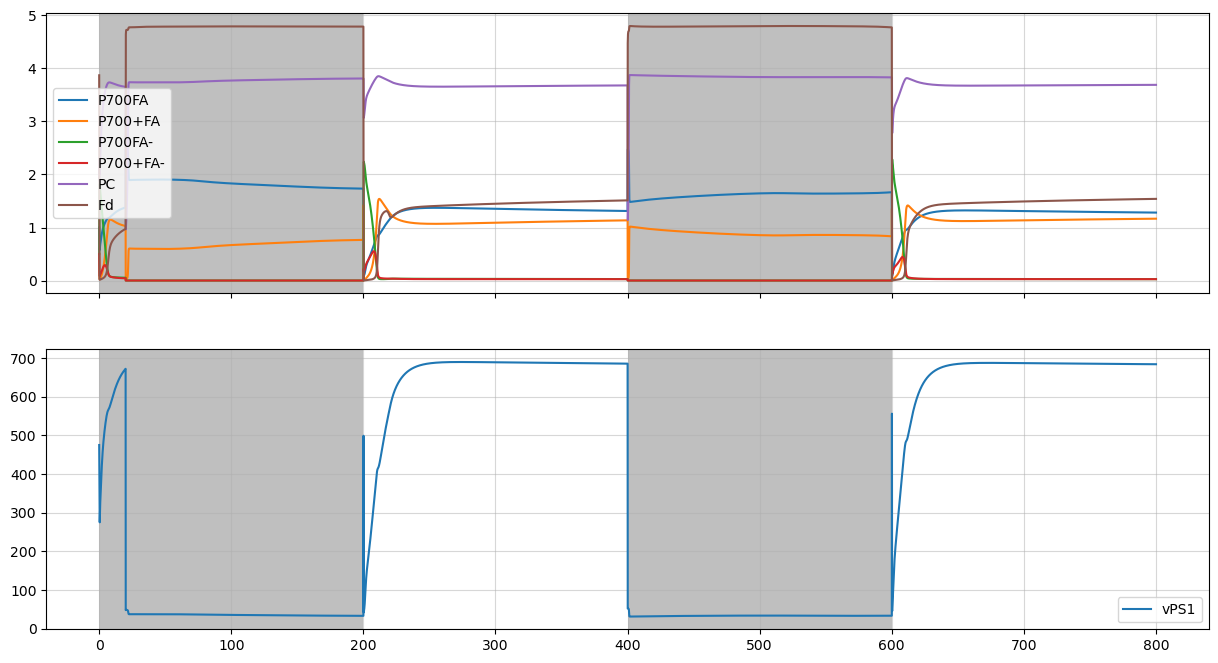

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
ax[0].plot(results_df.index, results_df["P700FA"], label="P700FA")
ax[0].plot(results_df.index, results_df["P700+FA"], label="P700+FA")
ax[0].plot(results_df.index, results_df["P700FA-"], label="P700FA-")
ax[0].plot(results_df.index, results_df["P700+FA-"], label="P700+FA-")
ax[0].plot(results_df.index, results_df["PC"], label="PC")
ax[0].plot(results_df.index, results_df["Fd"], label="Fd")
ax[0].legend()

ax[1].plot(flux_df.index, flux_df["vPS1"], label="vPS1")
#ax[1].plot(flux_df.index, flux_df["vFdred"], label="vFdred")
#ax[1].plot(flux_df.index, flux_df["vPCox"], label="vPCox")
ax[1].legend()


for period in dark_intervals:
    for i, _ in enumerate(ax):
        ax[i].axvspan(period[0], period[1], facecolor='grey', alpha=0.5)

for i, _ in enumerate(ax):
    #ax[i].set_xlim(599.98, 600.08)
    ax[i].grid(alpha = 0.5)
fig.show()

In [ ]:
folder = "figures/playground/old_model/PS1_states/"
#name = input("Enter the name of the file: ")
zoom = "600"
#zoom = "broadview"

name = f"pfd_{pfd_dark}_{pfd_light}__interval_{interval_length}__zoom_{zoom}"
# eg "200_interval__zoom_600__w_PC_Fd"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15), sharex=True)
ax[0].plot(results_df.index, results_df["ATP"], label="ATP")
ax[0].plot(results_df.index, results_df["NADPH"], label="NADPH")
ax[0].plot(results_df.index, results_df["Psbs"], label="Psbs")
ax[0].plot(results_df.index, results_df["H2O2"], label="H2O2")
ax[0].legend()

ax[1].plot(flux_df.index, flux_df["vPS2"], label="vPS2")
ax[1].plot(flux_df.index, flux_df["vCyc"], label="vCyc")
ax[1].plot(flux_df.index, flux_df["vRuBisCO"], label="vRubisco")
ax[1].plot(flux_df.index, flux_df["vMehler"], label="vMehler")
ax[1].legend()


for period in dark_intervals:
    for i, _ in enumerate(ax):
        ax[i].axvspan(period[0], period[1], facecolor='grey', alpha=0.5)

for i, _ in enumerate(ax):
    #ax[i].set_xlim(599.98, 600.08)
    ax[i].grid(alpha = 0.5)
fig.show()

In [28]:
folder = "figures/playground/old_model/general_understanding/"
#name = input("Enter the name of the file: ")
# eg "200_interval__zoom_600__w_PC_Fd"

#zoom = "600"
zoom = "broadview"

name = f"pfd_{pfd_dark}_{pfd_light}__interval_{interval_length}__zoom_{zoom}"

os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")

In [21]:
os.getcwd()

'c:\\Users\\andre\\OneDrive\\Bildung\\3_HHU\\quant_Bio\\6th\\BA\\QTB_modelling'